In [17]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy 

from matplotlib import pyplot as plt

import utils.helpers as hp

In [2]:
def create_paragraph_dict(path:str, 
                          lines_to_skip:int, 
                          book_title:str, 
                          cut_num:int = 200,
                          **kwargs)->dict:

    cleaner_functions = {'pyrates': hp.pre_process_pyrates,
                         'rc': hp.pre_process_rc,
                         'wj': hp.pre_process_weekly_journal,
                         'gt': hp.pre_process_gt}
    
    clean_func = cleaner_functions[book_title]

    with open(path, 'r') as file:
        for _ in range(lines_to_skip):
            next(file)
        text = file.read()

    paragraphs = text.split('\n\n')

    paragraph_dict = {}

    for i, paragraph in enumerate(paragraphs):
        clean_p = clean_func(paragraph, **kwargs)
        if len(clean_p.split()) >= cut_num:
            paragraph_dict[book_title + '_' + str(i)] = clean_p


    return paragraph_dict

In [12]:
def determine_custom_tf_idf_matrix(corpus:list)->pd.DataFrame:
    
    vectorizer = TfidfVectorizer(
        input="content", smooth_idf=False, norm="l2", use_idf=False
    )
    x = vectorizer.fit_transform(corpus)

    n_samples, _ = x.shape
    array_sums = np.sum(x.toarray() > 0, axis=0)

    # TfidfVectorizer uses np.log(n_samples/array_sums) + 1
    idf_scale = np.log(n_samples / array_sums)
    tf_idf = x.toarray() * idf_scale

    return pd.DataFrame(tf_idf)

In [13]:
def determine_tf_idf_matrix(corpus:list)->pd.DataFrame:
    
    vectorizer = TfidfVectorizer()
    x = vectorizer.fit_transform(corpus)

    return pd.DataFrame(x.toarray())

In [14]:
def determine_distance_matrix(tf_idf:pd.DataFrame)->pd.DataFrame:
    return pd.DataFrame(euclidean_distances(tf_idf))

In [3]:
pyrates_paragraph_dict = create_paragraph_dict(path = '../books/gen_history_of_the_pyrates.txt',
                                               lines_to_skip=52,
                                               book_title='pyrates',
                                               cut_num=150)

In [4]:
len(pyrates_paragraph_dict)

40

In [5]:
print(pyrates_paragraph_dict['pyrates_67'])

times marius sylla rome greatest strength yet torn pieces factions two great men every thing concerned publick good altogether neglected certain pyrates broke cicilia country asia minor situate coast mediterranean betwixt syria east whence divided mount tauris armenia minor west beginning mean inconsiderable two three ships men cruised greek islands taking ships ill arm  weakly defended however taking many prizes soon increased wealth power first action  made noise taking julius cæsar yet youth obliged fly cruelties sylla sought life went bithinia sojourned nicomedes king country return back sea met taken pyrates near island pharmacusa pyrates barbarous custom tying prisoners back back throwing sea supposing cæsar person high rank purple robes number attendants thought would profit preserve hopes receiving great sum ransom therefore told liberty provided would pay twenty talents judg  high demand money three thousand six hundred pounds sterling smiled accord promised fifty talents plea

In [ ]:
rc_paragraph_dict = create_paragraph_dict(path = '../../books/daniel_defoe/robinson_crusoe.txt',
                                               lines_to_skip=12,
                                               book_title='rc',
                                               cut_num=150)

In [7]:
len(rc_paragraph_dict)

35

In [8]:
print(rc_paragraph_dict['rc_13'])

slept well night sea-sick cheerful looking wonder upon sea rough terrible day could calm pleasant little time lest good resolutions continue companion indeed enticed away comes well bob says clapping upon shoulder warrant frighted want last night blew capful wind —a capful call said terrible storm.—a storm fool replied call storm nothing give us good ship sea-room think nothing squall wind youre fresh-water sailor bob come let us make bowl punch well forget see charming weather make short sad part story went old way sailors punch made made drunk one nights wickedness drowned repentance reflections upon past conduct resolutions future word sea returned smoothness surface settled calmness abatement storm hurry thoughts fears apprehensions swallowed sea forgotten current former desires returned entirely forgot vows promises made distress found indeed intervals reflection serious thoughts endeavour return sometimes shook roused distemper applying drinking company soon mastered return fits 

In [ ]:
gt_paragraph_dict = create_paragraph_dict(path = '../../books/jonathan_swift/gullivers_travels.txt',
                                               lines_to_skip=28,
                                               book_title='gt',
                                               cut_num=150)

In [10]:
len(gt_paragraph_dict)

76

In [11]:
print(gt_paragraph_dict['gt_9'])

hope ready publicly whenever shall called great frequent urgency prevailed publish loose uncorrect account travels directions hire young gentleman either university put order correct style cousin dampier advice book called voyage round world remember gave power consent thing omitted much less thing inserted therefore latter renounce every thing kind particularly paragraph majesty queen anne pious glorious memory although reverence esteem human species interpolator ought considered inclination decent praise animal composition master houyhnhnm besides fact altogether false knowledge england part majestys reign govern chief minister nay even two successively first whereof lord godolphin second lord oxford made say thing likewise account academy projectors several passages discourse master houyhnhnm either omitted material circumstances minced changed manner hardly know work formerly hinted something letter pleased answer afraid giving offence people power watchful press apt interpret puni

In [ ]:
mist_text_paths = Path('../../books/mist_weekly_journal_text').glob('*')
mist_text_files = [f for f in mist_text_paths]

In [ ]:
mist_paragraph_dict = {}
file_num = 0

for f in mist_text_files:
    print(f)
    temp = create_paragraph_dict(f,0,'wj',150)
    
    for k, v in temp.items():
        mist_paragraph_dict[k+'_'+str(file_num)] = v
    
    file_num +=1

In [26]:
def random_sample_dict(data:dict, number:int)->dict:

    keys = list(data.keys())
    sample_keys = np.random.choice(keys, size=number, replace=False)

    sample_dict = {}
    for k in sample_keys:
        sample_dict[k] = data[k]

    return sample_dict

In [42]:
sample_pyrates = random_sample_dict(pyrates_paragraph_dict, 20)
sample_rc = random_sample_dict(rc_paragraph_dict, 20)
sample_mist = random_sample_dict(mist_paragraph_dict, 20)

In [43]:
corpus = list(sample_pyrates.values())+list(sample_rc.values())+list(sample_mist.values())
tf_idf = determine_tf_idf_matrix(corpus=corpus)

In [44]:
dist_matrix = determine_distance_matrix(tf_idf=tf_idf)
dist_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.000000,1.371344,1.374165,1.395060,1.354518,1.301246,1.358174,1.390815,1.288732,1.375507,...,1.406698,1.408022,1.407254,1.409628,1.401058,1.413052,1.410515,1.406901,1.409253,1.409341
1,1.371344,0.000000,1.367691,1.398799,1.359956,1.355790,1.340284,1.357799,1.360814,1.382818,...,1.405059,1.393725,1.407469,1.402434,1.401284,1.412414,1.403291,1.404638,1.397142,1.397168
2,1.374165,1.367691,0.000000,1.005774,1.393690,1.375722,1.161160,1.403553,1.375808,0.919228,...,1.406878,1.412970,1.413349,1.411845,1.411434,1.414214,1.412987,1.413951,1.410780,1.408655
3,1.395060,1.398799,1.005774,0.000000,1.407223,1.391012,1.122375,1.397278,1.382578,0.839698,...,1.409235,1.413372,1.413173,1.410992,1.411339,1.414214,1.408523,1.403822,1.412491,1.412456
4,1.354518,1.359956,1.393690,1.407223,0.000000,1.308028,1.365901,1.383798,1.334212,1.382047,...,1.412494,1.405140,1.404550,1.395974,1.398974,1.412734,1.409657,1.395690,1.404135,1.398899


In [45]:
document_labels = list(sample_pyrates.keys())+list(sample_rc.keys())+list(sample_mist.keys())

### Create clusters from `TF IDF` matrix

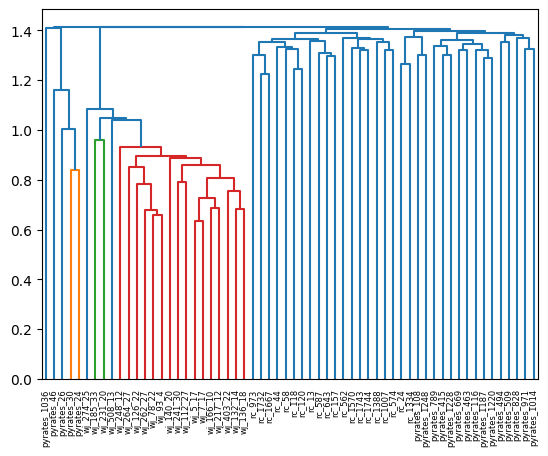

In [46]:
comp_linkage = hierarchy.linkage(tf_idf, method = 'complete')
hierarchy.dendrogram(comp_linkage, labels=document_labels)
plt.show()

### Use all paragraphs

In [ ]:
corpus_all = list(pyrates_paragraph_dict.values())+list(rc_paragraph_dict.values())+list(mist_paragraph_dict.values())
tf_idf_all = determine_tf_idf_matrix(corpus=corpus_all)
document_labels_all = list(pyrates_paragraph_dict.keys())+list(rc_paragraph_dict.keys())+list(mist_paragraph_dict.keys())

In [55]:
comp_linkage_all = hierarchy.linkage(tf_idf_all, method = 'complete')
assignments = hierarchy.cut_tree(comp_linkage_all,n_clusters=2).T[0]

In [56]:
assignment_df = pd.DataFrame({'document_labels': document_labels_all, 'assignments': assignments})
assignment_df['book'] = assignment_df['document_labels'].str.split('_').str[0]

In [57]:
result = assignment_df.groupby(['assignments', 'book']).size().reset_index(name='count')
result.sort_values('count', ascending=False)

,assignments,book,count
2,1,wj,198
0,0,pyrates,40
1,0,rc,35


In [59]:
print(rc_paragraph_dict['rc_1334'])

gave diverting account life many extraordinary events many adventures befallen years abroad world particularly remarkable viz voyage engaged misfortune five times shipped unshipped never go place whither ships first designed first intent gone martinico went board ship bound thither st. maloes forced lisbon bad weather ship received damage running aground mouth river tagus obliged unload cargo finding portuguese ship bound madeiras ready sail supposing easily meet vessel bound martinico went board order sail madeiras master portuguese ship indifferent mariner reckoning drove fyal however happened find good market cargo corn therefore resolved go madeiras load salt isle may go away newfoundland remedy exigence go ship pretty good voyage far banks call place catch fish meeting french ship bound france quebec river canada thence martinico carry provisions thought opportunity complete first design came quebec master ship died ship proceeded farther next voyage shipped france ship burnt took

In [60]:
print(pyrates_paragraph_dict['pyrates_108'])

whereas received information several persons subjects great britain since 24th day june year lord 1715 committed divers pyracies robberies upon high-seas west-indies adjoyning plantations hath may occasion great damage merchants great britain others trading parts tho appointed force judge sufficient suppressing said pyrates yet effectually put end thought fit advice privy council issue royal proclamation hereby promise declare case said pyrates shall 5th september year lord 1718 surrender one principal secretaries state great britain ireland governor deputy governor plantations beyond seas every pyrate pyrates surrendering aforesaid shall gracious pardon pyracy pyracies committed fifth january next ensuing hereby strictly charge command admirals captains officers sea governors commanders forts castles places plantations officers civil military seize take pyrates shall refuse neglect surrender accordingly hereby declare case person persons 6th day september 1718 shall discover seize cau

In [61]:
rc_para = set(rc_paragraph_dict['rc_1334'].split(' '))

In [62]:
p_para = set(pyrates_paragraph_dict['pyrates_108'].split(' '))

In [63]:
rc_para.intersection(p_para)

{'damage',
 'master',
 'may',
 'next',
 'occasion',
 'one',
 'person',
 'received',
 'said',
 'sea',
 'shall',
 'ship',
 'thought',
 'vessel',
 'viz'}